In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import gc
import os
import json
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Memory management function
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Training history tracking class
class TrainingHistory:
    def __init__(self):
        self.history = {
            'epoch': [],
            'learning_rate': [],
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': [],
            'precision': [],
            'recall': [],
            'f1_score': [],
            'timestamp': [],
            'test_probs': [],
            'test_labels': [],
            'confusion_matrix_path': []
        }

    def update(self, epoch, lr, train_loss, train_acc, test_loss, test_acc, metrics, probs=None, labels=None):
        self.history['epoch'].append(epoch)
        self.history['learning_rate'].append(lr)
        self.history['train_loss'].append(float(train_loss))
        self.history['train_acc'].append(float(train_acc))
        self.history['test_loss'].append(float(test_loss))
        self.history['test_acc'].append(float(test_acc))
        self.history['precision'].append(metrics['precision'])
        self.history['recall'].append(metrics['recall'])
        self.history['f1_score'].append(metrics['f1'])
        self.history['timestamp'].append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        self.history['confusion_matrix_path'].append(f'confusion_matrix_epoch_{epoch}.png')

        if probs is not None and labels is not None:
            # Convert numpy arrays to lists before storing
            self.history['test_probs'].append([prob.tolist() for prob in probs])
            self.history['test_labels'].append([int(label) for label in labels])

    def save(self, file_path):
        """Save the training history to a JSON file."""
        with open(file_path, 'w') as f:
            json.dump(self.history, f, indent=4)

# Data Processing and Augmentation
class SVHNDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.data = datasets.SVHN(root='./data', split=split, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        
        # Convert the image to a numpy array before applying augmentations
        image = np.array(image)

        if self.transform:
            # Apply transformations with named arguments
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

# Data augmentation class
class SVHNAugmentation:
    def __init__(self):
        self.train_transform = A.Compose([
            A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.0)),
            A.HorizontalFlip(),
            A.Rotate(limit=20),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
            ToTensorV2()
        ])
        
        self.test_transform = A.Compose([
            A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
            ToTensorV2()
        ])

    def get_train_transform(self):
        return self.train_transform

    def get_test_transform(self):
        return self.test_transform

# Define the VGG model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
        
def plot_confusion_matrix(y_true, y_pred, epoch, learning_rate, save_path):
    """
    Create and save confusion matrix as an image file.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        epoch: Current epoch number
        learning_rate: Learning rate used for training
        save_path: Path to save the confusion matrix plot (including filename)
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Epoch {epoch} - LR {learning_rate}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the confusion matrix plot
    plt.savefig(save_path)
    plt.close()  # Close the figure to free memory
# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({'Loss': running_loss / total, 'Acc': 100. * correct / total})
        
    return running_loss / len(train_loader), 100. * correct / total

# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    metrics = {
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }
    

    return avg_loss, accuracy, all_probs, all_labels, metrics
    
def train_model_with_params(params):
    """
    Train model with specific parameters
    params: dictionary containing training parameters
    """
    try:
        # Clear memory before starting new training
        clear_memory()
        
        # Extract parameters
        num_epochs = params['num_epochs']
        batch_size = 64
        learning_rate = params['learning_rate']
        
        # Create unique identifier for this training run
        run_id = f"epochs{num_epochs}_lr{learning_rate}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        # Initialize history tracker
        history = TrainingHistory()
        
        # Data loading
        augmentation = SVHNAugmentation()
        train_dataset = SVHNDataset(split='train', transform=augmentation.get_train_transform())
        test_dataset = SVHNDataset(split='test', transform=augmentation.get_test_transform())
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Model initialization
        model = VGG().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Create directory for this run
        run_dir = f'./models/{run_id}'
        os.makedirs(run_dir, exist_ok=True)
        
        # Training loop
        best_acc = 0
        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
            test_loss, test_acc, probs, labels, metrics = evaluate(model, test_loader, criterion)
            
            # Update history
            history.update(epoch + 1, learning_rate, train_loss, train_acc, 
                         test_loss, test_acc, metrics, probs=probs, labels=labels)
            
            # Create predictions from probabilities
            predictions = np.argmax(probs, axis=1)
            
            # Plot confusion matrix
            plot_confusion_matrix(
                y_true=labels,
                y_pred=predictions,
                epoch=epoch + 1,
                learning_rate=learning_rate,
                save_path=f'{run_dir}/confusion_matrix_epoch_{epoch + 1}_lr_{learning_rate}.png'
            )
            
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc,
                    'params': params  # Save training parameters
                }, f'{run_dir}/best_model.pth')
            
            # Save history after each epoch
            history.save(f'{run_dir}/training_history.json')
        
        # Clear memory after training
        clear_memory()
        
        return best_acc, run_id
        
    except Exception as e:
        print(f"Error in training with parameters {params}: {e}")
        return None, None

def doublemain():
    # Define different parameter combinations to try
    parameter_combinations = [
        
        {
            'num_epochs': 50,
            'learning_rate': 0.0005
        }
    ]
    
    # Dictionary to store results
    results = {}
    
    # Train models with different parameters
    for params in parameter_combinations:
        print(f"\nStarting training with parameters: {params}")
        best_acc, run_id = train_model_with_params(params)
        
        if best_acc is not None:
            results[run_id] = {
                'parameters': params,
                'best_accuracy': best_acc
            }
    
    # Save overall results
    with open('./models/all_training_results.json', 'w') as f:
        json.dump(results, f, indent=4)
    
    # Print summary
    print("\nTraining Summary:")
    for run_id, result in results.items():
        print(f"\nRun ID: {run_id}")
        print(f"Parameters: {result['parameters']}")
        print(f"Best Accuracy: {result['best_accuracy']:.2f}%")
# Main function
def main():
    try:
        # Hyperparameters
        num_epochs = 3
        batch_size = 64  # Adjusted batch size for stability
        learning_rate = 0.001
        
        # Initialize history tracker
        history = TrainingHistory()
        
        # Data loading
        augmentation = SVHNAugmentation()
        train_dataset = SVHNDataset(split='train', transform=augmentation.get_train_transform())
        test_dataset = SVHNDataset(split='test', transform=augmentation.get_test_transform())
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        print('loaded')
        
        # Model initialization
        model = VGG().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Ensure the models directory exists
        os.makedirs('./models', exist_ok=True)
        
        # Training loop
        best_acc = 0
        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
            test_loss, test_acc, probs, labels, metrics = evaluate(model, test_loader, criterion)
            
            # Update history
            history.update(epoch + 1, learning_rate, train_loss, train_acc, 
                         test_loss, test_acc, metrics, probs=probs, labels=labels)
            
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc,
                }, './models/best_model.pth')
            
            # Save history after each epoch
            history.save('./models/training_historyfor3epoch.json')
        
    except Exception as e:
        print(f"Error in main function: {e}")
        raise
if __name__ == "__main__":
    main()

Using device: cuda
Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
loaded


Evaluating:  95%|█████████▌| 388/407 [00:04<00:00, 90.69it/s]

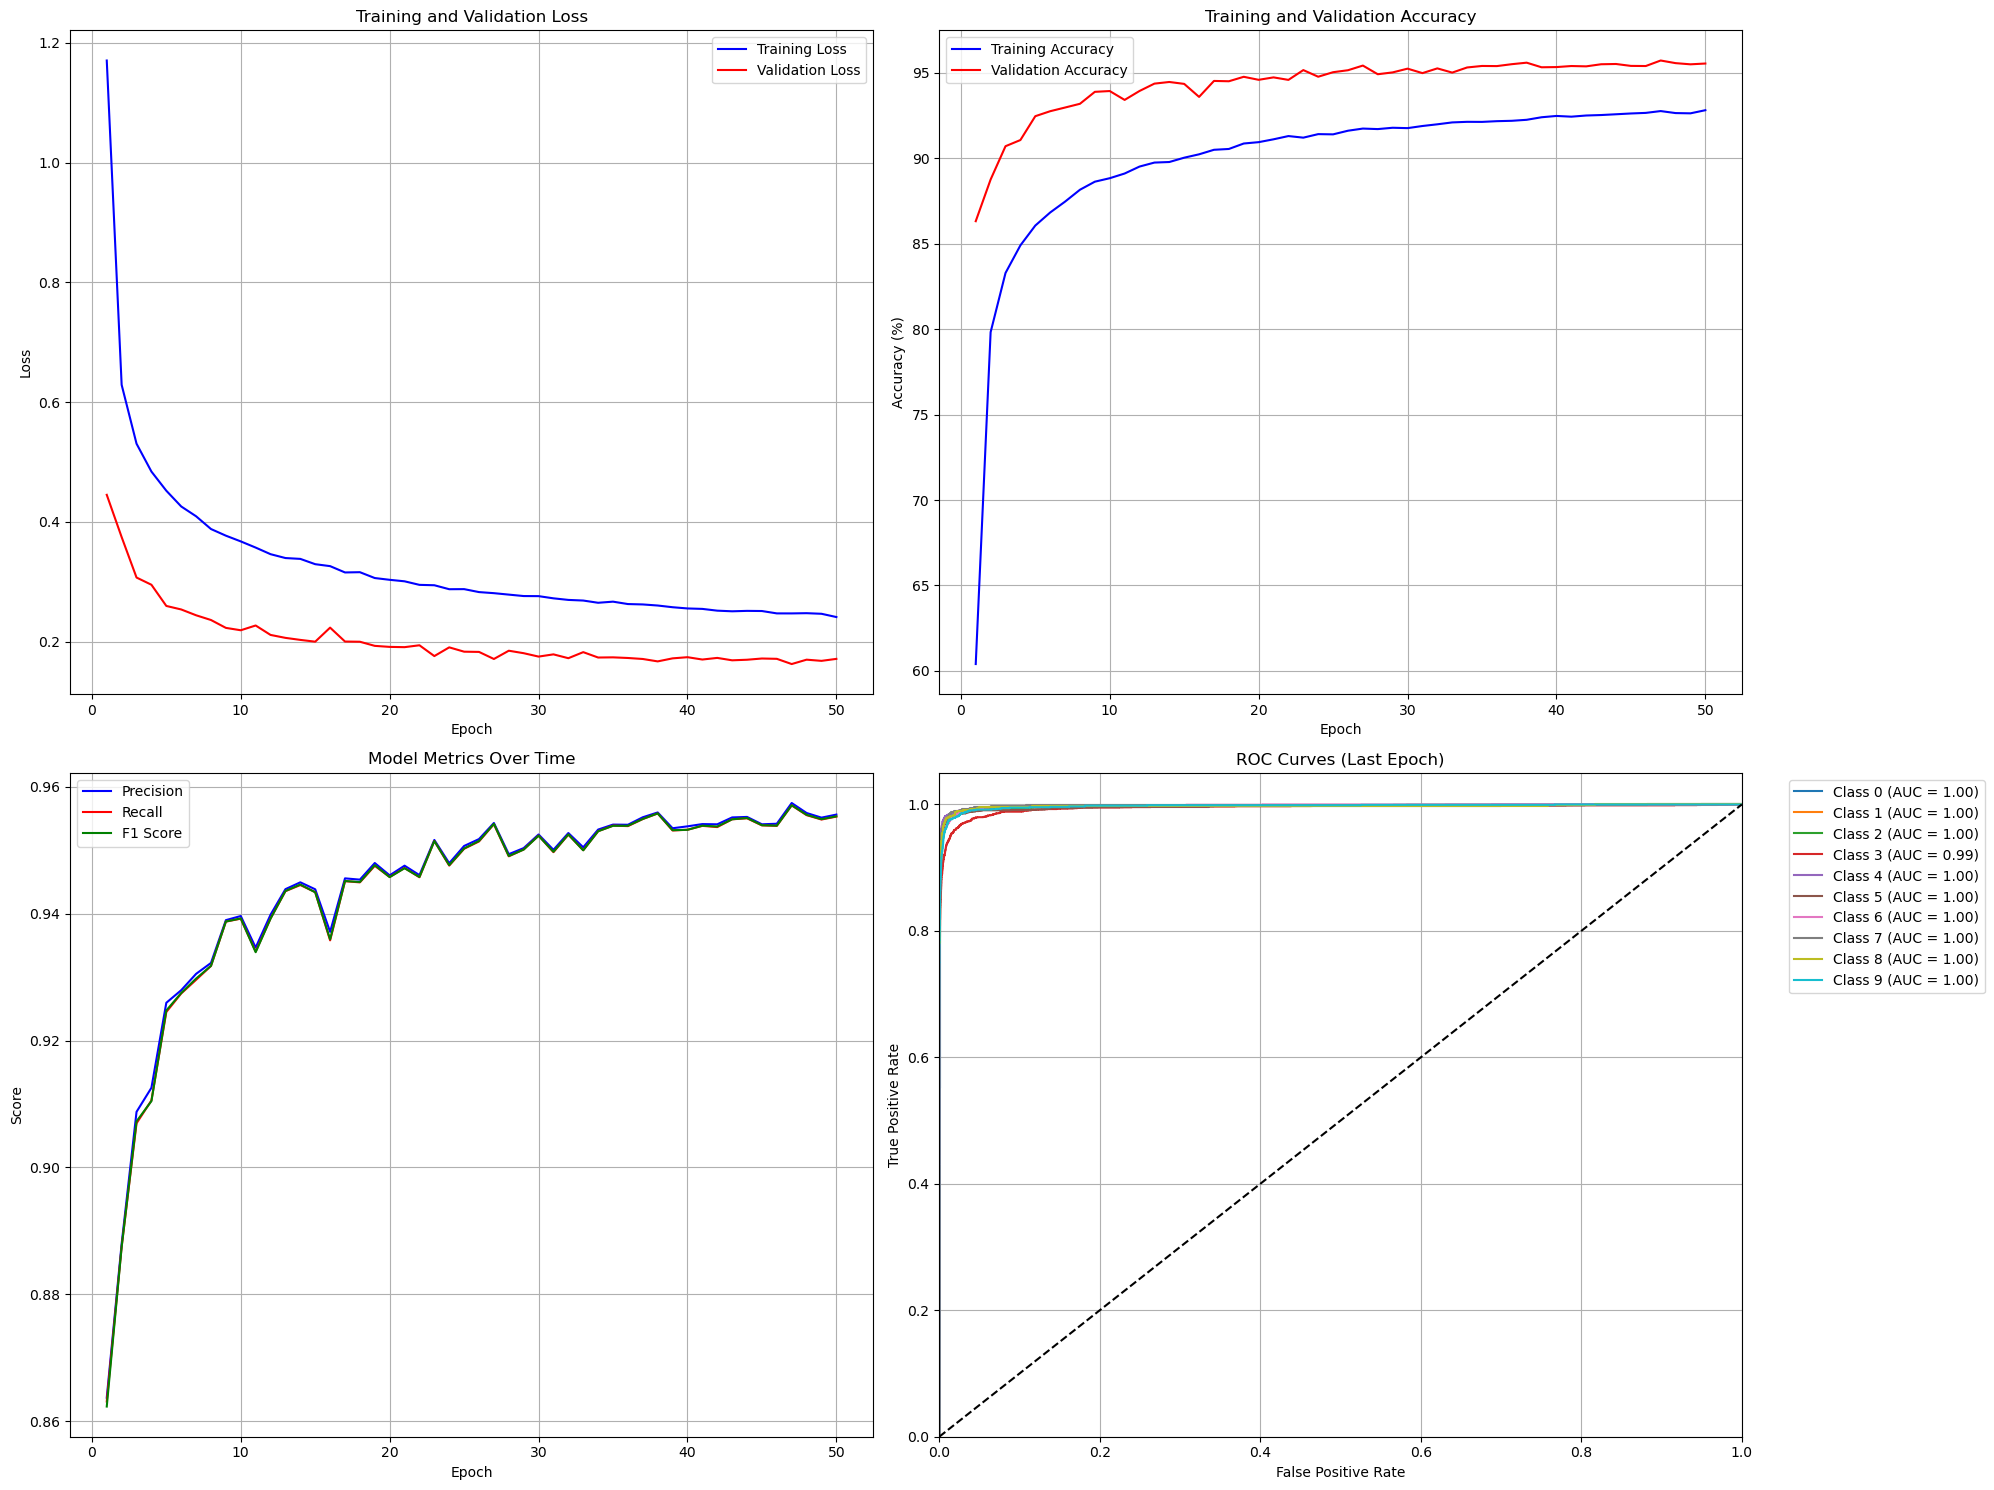

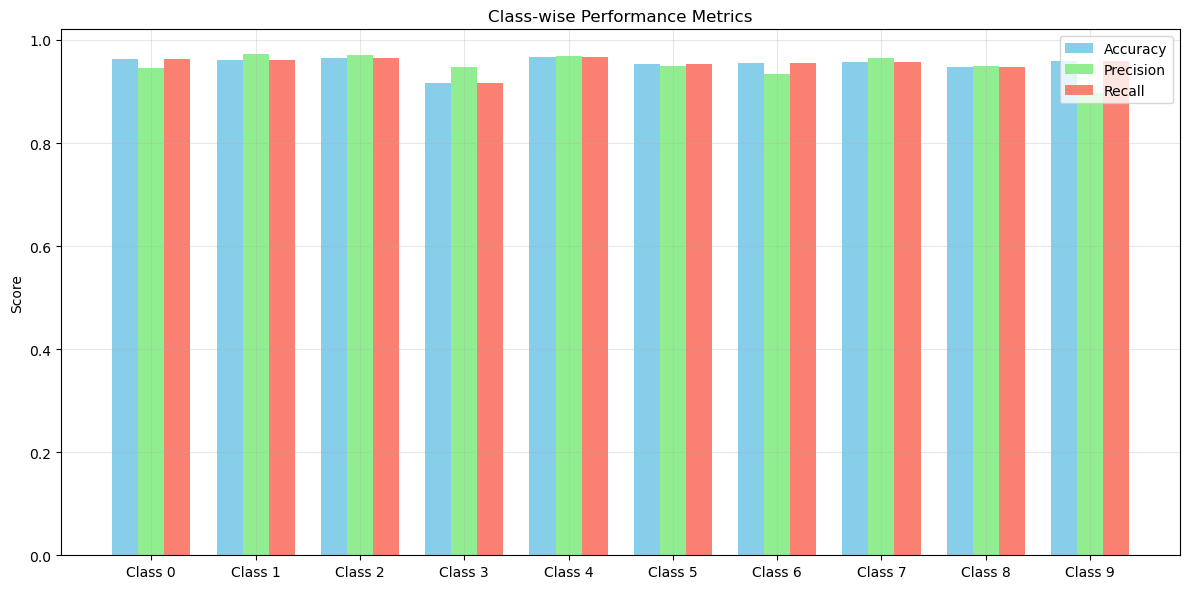

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import json

def create_training_plots(history):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training and Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['epoch'], history['train_loss'], 'b-', label='Training Loss')
    plt.plot(history['epoch'], history['test_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # 2. Training and Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['epoch'], history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(history['epoch'], history['test_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    # 3. Precision, Recall, and F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['epoch'], history['precision'], 'b-', label='Precision')
    plt.plot(history['epoch'], history['recall'], 'r-', label='Recall')
    plt.plot(history['epoch'], history['f1_score'], 'g-', label='F1 Score')
    plt.title('Model Metrics Over Time', fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    
    # 4. ROC Curves for last epoch
    plt.subplot(2, 2, 4)
    
    # Get the last epoch's probabilities and labels
    last_probs = np.array(history['test_probs'][-1])
    last_labels = np.array(history['test_labels'][-1])
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    # Calculate ROC curve for each class
    for i in range(10):  # 10 classes for SVHN
        fpr, tpr, _ = roc_curve((last_labels == i).astype(int), last_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Last Epoch)', fontsize=12)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    # Remove the save and close lines
    # plt.savefig('./models/training_plots.png', bbox_inches='tight', dpi=300)
    # plt.close()
    plt.show()  # Display the plots

def create_class_performance_plot(history):
    # Get the last epoch's probabilities and labels
    last_probs = np.array(history['test_probs'][-1])
    last_labels = np.array(history['test_labels'][-1])
    predictions = np.argmax(last_probs, axis=1)
    
    # Calculate class-wise metrics
    class_accuracy = []
    class_precision = []
    class_recall = []
    
    for i in range(10):
        class_mask = last_labels == i
        if np.sum(class_mask) > 0:
            class_accuracy.append(np.mean(predictions[class_mask] == i))
            class_precision.append(np.sum((predictions == i) & (last_labels == i)) / np.sum(predictions == i))
            class_recall.append(np.sum((predictions == i) & (last_labels == i)) / np.sum(last_labels == i))
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(10)
    width = 0.25
    
    ax.bar(x - width, class_accuracy, width, label='Accuracy', color='skyblue')
    ax.bar(x, class_precision, width, label='Precision', color='lightgreen')
    ax.bar(x + width, class_recall, width, label='Recall', color='salmon')  # Corrected indentation
    
    ax.set_ylabel('Score')
    ax.set_title('Class-wise Performance Metrics', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([f'Class {i}' for i in range(10)])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()  # Display the plot

# Load the training history
with open('./models/experiment 16/training_history.json', 'r') as f:
    history = json.load(f)

# Create the plots
create_training_plots(history)
create_class_performance_plot(history)

Total epochs available: 50


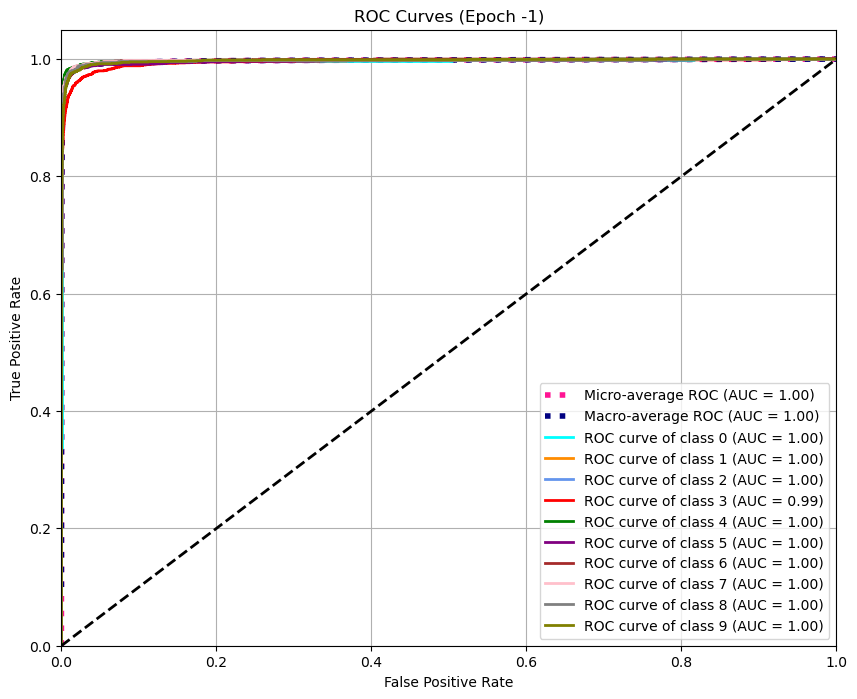


AUC Scores for Epoch 0:
Micro-average AUC: 0.9970
Macro-average AUC: 0.9970

Class-wise AUC scores:
Class 0: 0.9966
Class 1: 0.9964
Class 2: 0.9974
Class 3: 0.9943
Class 4: 0.9979
Class 5: 0.9959
Class 6: 0.9981
Class 7: 0.9983
Class 8: 0.9974
Class 9: 0.9973


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_macro_micro_auc(test_probs, test_labels, epoch_idx=-1):
    """
    绘制ROC曲线
    epoch_idx: 要查看的epoch索引，默认为-1（最后一个epoch）
    """
    # 获取指定epoch的数据
    probs = test_probs[epoch_idx]  # shape: (26032, 10)
    labels = test_labels[epoch_idx]  # shape: (26032,)
    
    # 确保数据维度正确
    n_classes = probs.shape[1]
    labels_one_hot = label_binarize(labels, classes=range(n_classes))
    
    # 计算每个类别的ROC曲线和AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # 计算每个类的ROC曲线和AUC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 计算micro-average ROC曲线和AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one_hot.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # 计算macro-average ROC曲线和AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # 绘图
    plt.figure(figsize=(10, 8))
    
    # Plot micro-average ROC curve
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
        color='deeppink',
        linestyle=':',
        linewidth=4,
    )
    
    # Plot macro-average ROC curve
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
        color='navy',
        linestyle=':',
        linewidth=4,
    )
    
    # Plot ROC curves for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 
                   'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})',
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (Epoch {epoch_idx})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    # Print AUC scores
    print(f"\nAUC Scores for Epoch {epoch_idx+1}:")
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
    print("\nClass-wise AUC scores:")
    for i in range(n_classes):
        print(f"Class {i}: {roc_auc[i]:.4f}")

# 执行绘图
try:
    test_probs = np.array(history['test_probs'])
    test_labels = np.array(history['test_labels'])
    
    print(f"Total epochs available: {len(test_probs)}")
    
    # 绘制最后一个epoch的ROC曲线
    plot_macro_micro_auc(test_probs, test_labels, epoch_idx=-1)
    
    # 如果您想查看特定epoch的结果，可以指定epoch_idx
    # 例如，查看第一个epoch的结果：
    # plot_macro_micro_auc(test_probs, test_labels, epoch_idx=0)
    
except Exception as e:
    print(f"Error occurred during plotting: {e}")

In [16]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_macro_micro_auc(test_probs, test_labels, epoch_idx=-1):
    # Convert to NumPy arrays
    probs = np.array(test_probs[epoch_idx])  # Ensure this is a 2D array
    labels = np.array(test_labels[epoch_idx])  # Ensure this is a 1D array
    
    n_classes = probs.shape[1]
    labels_one_hot = label_binarize(labels, classes=range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one_hot.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return roc_auc["micro"], roc_auc["macro"]

def create_summary_table(all_experiments):
    results = []
    
    for config_id, history in all_experiments.items():
        # Get the last epoch's results
        last_epoch = -1  # Index for the last epoch
        last_probs = np.array(history['test_probs'][last_epoch])  # Convert to NumPy array
        last_labels = np.array(history['test_labels'][last_epoch])  # Convert to NumPy array
        predictions = np.argmax(last_probs, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(last_labels, predictions)
        precision = precision_score(last_labels, predictions, average='macro')
        recall = recall_score(last_labels, predictions, average='macro')
        f1 = f1_score(last_labels, predictions, average='macro')
        
        # Compute AUC values
        micro_auc, macro_auc = plot_macro_micro_auc(history['test_probs'], history['test_labels'], last_epoch)
        
        # Get final loss values and learning rate
        final_train_loss = history['train_loss'][last_epoch]
        final_val_loss = history['test_loss'][last_epoch]
        learning_rate = history['learning_rate'][last_epoch]  # Get learning rate for the last epoch
        
        # Store results
        results.append({
            'num of Epoch': f'Epoch {len(history["epoch"])}',  # Use the number of epochs as Last Epoch
            'Learning Rate': f'{learning_rate:.6f}',  # Format learning rate
            'Accuracy': f'{accuracy:.4f}',
            'Precision': f'{precision:.4f}',
            'Recall': f'{recall:.4f}',
            'F1 Score': f'{f1:.4f}',
            'Micro AUC': f'{micro_auc:.4f}',
            'Macro AUC': f'{macro_auc:.4f}',
            'Final Train Loss': f'{final_train_loss:.4f}',
            'Final Val Loss': f'{final_val_loss:.4f}'
            
        })
    
    return pd.DataFrame(results)

# Load all experiment results
all_experiments = {}
for config_id in range(1, 19):
    file_path = f'./models/experiment {config_id}/training_history.json'
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                all_experiments[config_id] = json.load(f)
        except json.JSONDecodeError:
            print(f"Error decoding JSON for experiment {config_id} at {file_path}")
    else:
        print(f"Not found: {file_path}")

# Create and display summary table
summary_table = create_summary_table(all_experiments)
print("\nExperiment Results Summary:")
print(summary_table.to_string(index=False))

# Save to CSV (optional)
summary_table.to_csv('./experiment_summary.csv', index=False)


Experiment Results Summary:
num of Epoch Learning Rate Accuracy Precision Recall F1 Score Micro AUC Macro AUC Final Train Loss Final Val Loss
     Epoch 5      0.000500   0.9254    0.9228 0.9198   0.9208    0.9951    0.9950           0.4572         0.2564
     Epoch 5      0.001000   0.9225    0.9167 0.9169   0.9162    0.9949    0.9948           0.4357         0.2619
     Epoch 5      0.001500   0.9276    0.9211 0.9224   0.9215    0.9950    0.9949           0.4331         0.2575
    Epoch 10      0.000500   0.9354    0.9296 0.9329   0.9311    0.9958    0.9958           0.3661         0.2254
    Epoch 10      0.001000   0.9430    0.9395 0.9388   0.9390    0.9963    0.9962           0.3625         0.2078
    Epoch 10      0.001500   0.9393    0.9336 0.9365   0.9347    0.9961    0.9960           0.3535         0.2167
    Epoch 15      0.000500   0.9440    0.9406 0.9401   0.9401    0.9965    0.9964           0.3283         0.1988
    Epoch 15      0.001000   0.9456    0.9430 0.9413   0.94